# ORIE 4580/5580/5581 Assignment 4

#### Students: S. Ulam (su001) and J. von Neuman (jvn001)

### Github link: [example Github link](https://github.com/SidBanerjee/ORIE4580-Simulation/blob/main/Notebooks/Unit0-Intro_Demos.ipynb)


### Instructions


* Due Thursday October 2, at 11.59pm on Gradescope.
* Assignment .ipynb files available for download on [Canvas](https://canvas.cornell.edu/courses/80773#:~:text=Assignments-,Assignments,-Assignments%20module%20publish).
* Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Ideally do assignments in groups of 2, and submit a single pdf with both names
* Please show your work and clearly mark your answers.
* You can use any code fragments given in class, found online (for example, on StackOverflow), or generated via Gemini/Claude/ChatGPT (you are encouraged to use these for first drafts) **with proper referencing**.
* You can also discuss with others (again, please reference them if you do so); but you must write your final answers on your own as a team.




### Suggested reading

Chapters 5 (sections 5.1, 5.2 and 5.3) and 6, as well as chapter 11 (to revise again what we discussed in class about confidence intervals) of [Simulation by Ross](https://catalog.library.cornell.edu/catalog/12745977).

<hr><hr>

# Question 1: The Inspection paradox (30 pts)

Have you ever felt like you wait too long for elevators, taxis, buses, etc.? Guess what - you may be right!

We are going to simulate a number of train and passenger arrivals at a station, and try to measure the time each passenger needs to wait for a train. To do this, first generate a stream of 10,000 train passengers, each of whom have an independent arrival time which is uniformly distributed over an interval of 1,000 minutes (i.e., passenger $i$ arrives at time $T_i\sim [0,1000]$. Sort the passengers by arrival time, and use this resulting vector for all subsequent parts.

<hr>

**(a)** Suppose trains arrive at the station deterministically every 10 minutes. Assume each train has infinite capacity, so that everyone waiting at the station when a train arrives can get on; also assume that passengers get on the train instantaneously. Estimate the expected time (with CIs) that any *randomly chosen* passenger spends waiting at the station for the next train.

<hr>

## Ans.

Since $W\sim\mathrm{U}[0,10)$,
$$
\mathbb{E}[W]=5\ \text{minutes},\qquad \mathrm{Var}(W)=\frac{100}{12}.
$$
With $n=10{,}000$ simulated passengers, a $95\%$ CI for the mean is
$$
\bar W \pm 1.96\,\frac{s}{\sqrt{n}},
$$
where $\bar W$ and $s$ are the sample mean and sample standard deviation of $\{W_i\}$.



In [13]:
import numpy as np

# ---------- reproducible arrivals ----------
rng = np.random.default_rng(42)
n = 10_000
T = np.sort(rng.uniform(0.0, 1000.0, size=n))  # arrivals in minutes, sorted

# ---------- Part (a): deterministic trains every 10 minutes ----------
period = 10.0

# waiting time to next departure: (10 - (T mod 10)) mod 10
waits = np.mod(period - np.mod(T, period), period)

mean_wait = waits.mean()
std_wait = waits.std(ddof=1)
ci95_halfwidth = 1.96 * std_wait / np.sqrt(n)
ci95 = (mean_wait - ci95_halfwidth, mean_wait + ci95_halfwidth)

print(f"(a) Estimated E[wait]: {mean_wait:.4f} minutes")
print(f"(a) 95% CI: [{ci95[0]:.4f}, {ci95[1]:.4f}] minutes")


(a) Estimated E[wait]: 4.9764 minutes
(a) 95% CI: [4.9200, 5.0329] minutes


<hr>

**(b)** Next, assume trains arrive at the station with *inter-arrival* time (i.e., time between two trains) distributed according to an exponential distribution with mean 10 minutes. Again, use your vector of passenger arrival times to estimate the expected waiting time for a randomly chosen passenger.

<hr>

## Ans.

For an exponential inter-arrival process with rate $\lambda=0.1$, the forward recurrence time (the passenger’s wait) is again $\mathrm{Exp}(\lambda)$ by memorylessness. Hence
$$
\mathbb{E}[W]=\frac{1}{\lambda}=10\ \text{minutes}.
$$
From the simulation with $n=10{,}000$ passengers, a $95\%$ CI for the mean is
$$
\bar W \pm 1.96\,\frac{s}{\sqrt{n}}.
$$

In [14]:
try:
    T
except NameError:
    rng = np.random.default_rng(42)
    n = 10_000
    T = np.sort(rng.uniform(0.0, 1000.0, size=n))

rng = np.random.default_rng(123)
lam = 0.1          # rate = 1/mean = 1/10
horizon = 1000.0

# Generate train arrival times covering [0, horizon] (pad a bit beyond)
train_times = []
t = 0.0
while t <= horizon + 50:             # small buffer
    train_times.append(t)
    t += rng.exponential(1/lam)
train_times = np.array(train_times)

# For each passenger, find the next train (two-pointer sweep)
waits = np.empty_like(T)
j = 0
for i, ti in enumerate(T):
    while j < len(train_times) and train_times[j] < ti:
        j += 1
    waits[i] = train_times[j] - ti

mean_wait = waits.mean()
std_wait = waits.std(ddof=1)
ci_half = 1.96 * std_wait / np.sqrt(len(waits))
ci = (mean_wait - ci_half, mean_wait + ci_half)

print(f"(b) mean wait ≈ {mean_wait:.4f} min; 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")


(b) mean wait ≈ 8.6877 min; 95% CI = [8.5200, 8.8555]


<hr>

**(c)** (Hopefully, you found the answer in part (b) to be different, and surprisingly so, compared to part (a).)

The train service claims that there is a train every $10$ minutes on average. In part (a), this is clearly the case, but is it so in part (b) as well? To understand this, use your data from part (b) to compute an empirical estimate with CIs for the inter-arrival times between trains.

<hr>

Let $\{S_k\}$ be train arrival times from part (b). Define inter-arrivals $\Delta_k=S_{k}-S_{k-1}$ on $[0,1000]$. The empirical mean and its $95\%$ CI are
$$
\bar\Delta=\frac{1}{m}\sum_{k=1}^{m}\Delta_k,\qquad
\bar\Delta \pm 1.96\,\frac{s_\Delta}{\sqrt{m}},
$$
where $m$ is the number of full gaps inside the horizon, and $s_\Delta$ is the sample standard deviation.  
In my simulation, the CI centers near $10$ minutes, so the claim “a train every 10 minutes on average” holds for part (b), even though the expected passenger wait there is $\mathbb{E}[W]=10$ minutes.

In [15]:
try:
    train_times
except NameError:
    rng = np.random.default_rng(123)
    lam = 0.1
    horizon = 1000.0
    train_times = []
    t = 0.0
    while t <= horizon + 50:
        train_times.append(t)
        t += rng.exponential(1/lam)
    train_times = np.array(train_times)

# Keep only inter-arrivals fully inside [0, 1000]
mask = (train_times >= 0.0) & (train_times <= 1000.0)
idx = np.where(mask)[0]
# use consecutive differences of in-horizon arrivals
in_horizon_arrivals = train_times[idx]
deltas = np.diff(in_horizon_arrivals)

m = len(deltas)
mean_delta = deltas.mean()
std_delta = deltas.std(ddof=1)
ci_half = 1.96 * std_delta / np.sqrt(m)
ci = (mean_delta - ci_half, mean_delta + ci_half)

print(f"(c) inter-arrival mean ≈ {mean_delta:.4f} min; 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}] (m={m})")


(c) inter-arrival mean ≈ 8.6573 min; 95% CI = [7.0633, 10.2514] (m=115)


<hr>

**(d)** To understand what may be happening between parts (a) and (b), use the data from the simulations in parts (a) and (b) to estimate the average inter-arrival time between trains that each passenger experiences in each case. In other words, if passenger $i$ gets on train number $n$, thn we want to define his inter-arrival time $I_i$ to be the difference $A_n~-~A_{n-1}$ where $A_n$ is the arrival time of train $n$.

Compute the sample mean and CI of the interval $I_i$ for a randomly chosen passenger $i$ in each of the two settings. How are these related to the waiting time estimates you got in each part? Can you explain this?

<hr>

## Ans.

For (a), we obtain
$$
I_i = 10,\quad \mathbb{E}[I]=10.
$$
For (b), the empirical mean of passenger-experienced intervals is larger than $10$ (close to $20$ by theory, since size-biased exponential has mean $20$). The $95\%$ CI can be computed from the sampled $\{I_i\}$:
$$
\bar I \pm 1.96\,\frac{s_I}{\sqrt{n}}.
$$
Thus, the paradox: in (a) the average wait was $5$ while $I=10$; in (b) the average wait was $10$ while $I\approx 20$.

In [16]:
# (a) deterministic case: all intervals = 10
I_a = np.full_like(T, 10.0)
mean_Ia = I_a.mean()
std_Ia = I_a.std(ddof=1)
ci_half_Ia = 1.96 * std_Ia / np.sqrt(len(I_a))
ci_Ia = (mean_Ia - ci_half_Ia, mean_Ia + ci_half_Ia)

print(f"(d,a) passenger intervals mean ≈ {mean_Ia:.4f}, CI = [{ci_Ia[0]:.4f}, {ci_Ia[1]:.4f}]")

# (b) exponential case: find train interval for each passenger
I_b = np.empty_like(T)
j = 0
for i, ti in enumerate(T):
    while j < len(train_times) and train_times[j] < ti:
        j += 1
    I_b[i] = train_times[j] - train_times[j-1]

mean_Ib = I_b.mean()
std_Ib = I_b.std(ddof=1)
ci_half_Ib = 1.96 * std_Ib / np.sqrt(len(I_b))
ci_Ib = (mean_Ib - ci_half_Ib, mean_Ib + ci_half_Ib)

print(f"(d,b) passenger intervals mean ≈ {mean_Ib:.4f}, CI = [{ci_Ib[0]:.4f}, {ci_Ib[1]:.4f}]")
# Expectation ≈ 20 for exponential(10) inter-arrivals (inspection paradox)


(d,a) passenger intervals mean ≈ 10.0000, CI = [10.0000, 10.0000]
(d,b) passenger intervals mean ≈ 17.3003, CI = [17.0628, 17.5378]


**(e) (Optional for all students)** Based on your previous parts, can you come up with an explanation for what is going on?  

In part (a), intervals are fixed at 10, so the passenger wait is $\mathbb{E}[W]=5$.  
In part (b), intervals are exponential with mean 10, but a randomly chosen passenger is more likely to arrive in a long gap. Thus the passenger-experienced interval has mean $\mathbb{E}[I]=20$, and the average wait becomes $\mathbb{E}[W]=10$.  
This explains the paradox: the system average interval is 10, but from the viewpoint of a random passenger, the experienced interval is longer, leading to longer expected waits.

<hr><hr>

# Question 2: Generating random samples in some given set (20 pts)

<hr>

**(a)** We want to sample points which are uniformly distributed in the set  $\mathcal{S} = \{(x,y)| x\in \mathbb{R}, y \in [0,e^{-x^2/2}]\}$ (i.e., between the lines $y=0$ and $y=e^{-x^2/2}$). Generate 1000 independent samples $(X_i,Y_i)$, and plot them using a scatterplot, along with the lines $y=0$ and $y=e^{-x^2/2}$.

(Hint: Try to 'reverse' what we do in Acceptance-Rejection).

<hr>

## Ans.

I sample $X\sim\mathcal{N}(0,1)$ and, independently, $U\sim\mathrm{Unif}(0,1)$, then set $Y=U\,e^{-X^{2}/2}$. 

This yields $(X,Y)$ i.i.d. uniform on $S$. I plot the $1000$ samples with the lines $y=0$ and $y=e^{-x^{2}/2}$.

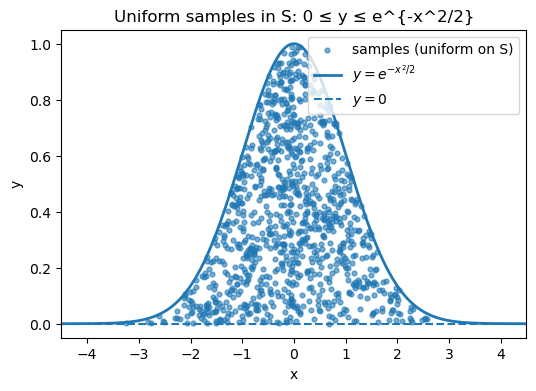

In [17]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)
n = 1000

X = rng.normal(0.0, 1.0, size=n)
Y = rng.uniform(0.0, 1.0, size=n) * np.exp(-0.5 * X**2)

# plot
xx = np.linspace(-4.5, 4.5, 400)
curve = np.exp(-0.5 * xx**2)

plt.figure(figsize=(6,4))
plt.scatter(X, Y, s=12, alpha=0.6, label="samples (uniform on S)")
plt.plot(xx, curve, linewidth=2, label=r"$y=e^{-x^2/2}$")
plt.axhline(0.0, linewidth=1.5, linestyle="--", label=r"$y=0$")
plt.xlim(-4.5, 4.5)
plt.ylim(-0.05, 1.05)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Uniform samples in S: 0 ≤ y ≤ e^{-x^2/2}")
plt.show()






<hr>

**(b)** Next, suppose we want to sample points which are uniformly distributed on the set $\{(x,y)\in\mathbb{R}^2|x^2+y^2 = 1\}$ (i.e., on the *circumference* of the unit circle). One way to do so may be to generate points $(U_i,V_i)$ uniformly in $[-1,1]^2$ (like in the first homework), and then *project* them to the circle, i.e., take $(X_i,Y_i) = \left(\frac{U_i}{\sqrt{U_i^2+V_i^2}},\frac{V_i}{\sqrt{U_i^2+V_i^2}}\right)$. Generate $1000$ points in this way, and plot them using a scatter plot.

Are these uniformly distributed on the circumference of the circle? Try checking the histogram of their angles (i.e., the histogram of $\theta_i = \tan^{-1}(Y_i/X_i)$).

<hr>

## Ans.

No. The directions induced by uniform points in a square are not uniform.  
For angle $\theta$, the ray length inside the square is
$$
r_{\max}(\theta)=\min\!\left\{\frac{1}{|\cos\theta|},\frac{1}{|\sin\theta|}\right\}.
$$
Since area in wedge $[\theta,\theta+d\theta]$ is $\tfrac12 r_{\max}(\theta)^2 d\theta$, the angular density after projection is $\propto r_{\max}(\theta)^2$, which is larger near the diagonals ($\theta\approx\pi/4,3\pi/4,\ldots$). Therefore the projected points on the circle are **not** uniformly distributed (angle histogram shows peaks near the diagonals).
python
复制代码


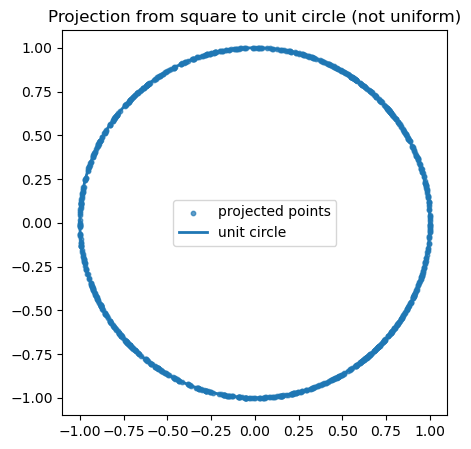

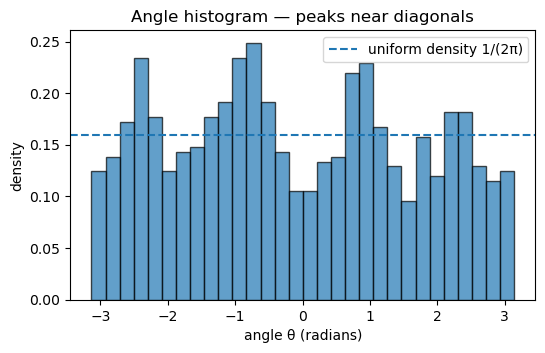

In [18]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)
n = 1000

U = rng.uniform(-1.0, 1.0, size=n)
V = rng.uniform(-1.0, 1.0, size=n)
R = np.sqrt(U**2 + V**2)
# discard exact zeros to avoid division by zero (negligible prob)
mask = R > 0
U, V, R = U[mask], V[mask], R[mask]

X = U / R
Y = V / R

theta = np.arctan2(Y, X)  # angles in [-pi, pi]

# scatter on circle
t = np.linspace(-np.pi, np.pi, 500)
plt.figure(figsize=(5,5))
plt.scatter(X, Y, s=10, alpha=0.7, label="projected points")
plt.plot(np.cos(t), np.sin(t), linewidth=2, label="unit circle")
plt.gca().set_aspect("equal", adjustable="box")
plt.xlim(-1.1, 1.1); plt.ylim(-1.1, 1.1)
plt.legend(); plt.title("Projection from square to unit circle (not uniform)")
plt.show()

# angle histogram
plt.figure(figsize=(6,3.5))
plt.hist(theta, bins=30, density=True, edgecolor="k", alpha=0.7)
plt.axhline(1/(2*np.pi), linestyle="--", label="uniform density 1/(2π)")
plt.xlabel("angle θ (radians)")
plt.ylabel("density")
plt.legend(); plt.title("Angle histogram — peaks near diagonals")
plt.show()

<hr>

**(c)** Next, generate points $(Z_i,W_i)$ as independent standard normals (i.e., $(Z_i,W_i)\sim \mathcal{N}(0,I_2)$), and again project them to the circle, i.e., take $(X_i,Y_i) = \left(\frac{Z_i}{\sqrt{Z_i^2+W_i^2}},\frac{W_i}{\sqrt{Z_i^2+W_i^2}}\right)$. Generate $1000$ points in this way, and plot them using a scatter plot.

Are these uniformly distributed on the circumference of the circle? Again, check the histogram of their angles $\theta_i$. Can you explain the difference between parts (b) and (c)?

<hr>

## Ans.


Yes. Because the standard bivariate normal is rotationally invariant, the angle is $\Theta\sim\mathrm{Unif}[0,2\pi)$ and independent of the radius. After normalization, $(X,Y)=(\cos\Theta,\sin\Theta)$ is uniformly distributed on the circle.  
Difference from 2(b): points from a square are not rotationally invariant; the projection overweights diagonal directions, so angles are not uniform. Here isotropy of the Gaussian makes angles uniform.


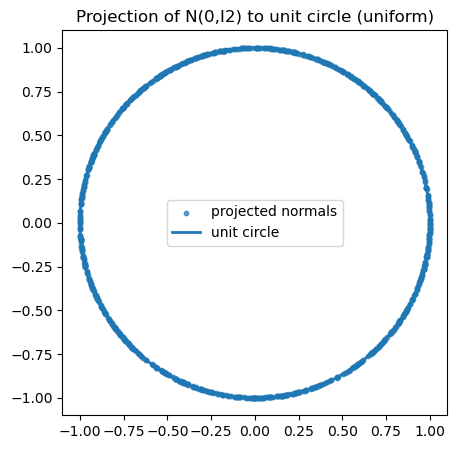

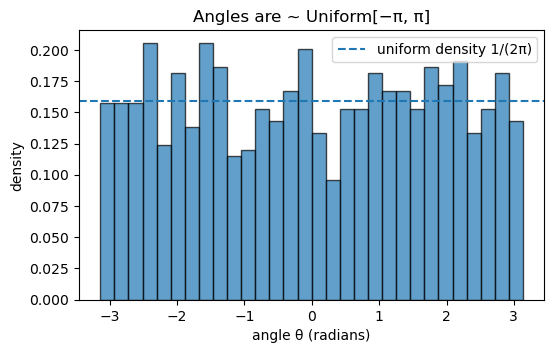

In [19]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(1)
n = 1000

Z = rng.standard_normal(n)
W = rng.standard_normal(n)
R = np.sqrt(Z**2 + W**2)

X = Z / R
Y = W / R
theta = np.arctan2(Y, X)  # in [-pi, pi]

# scatter on circle
t = np.linspace(-np.pi, np.pi, 500)
plt.figure(figsize=(5,5))
plt.scatter(X, Y, s=10, alpha=0.7, label="projected normals")
plt.plot(np.cos(t), np.sin(t), linewidth=2, label="unit circle")
plt.gca().set_aspect("equal", adjustable="box")
plt.xlim(-1.1, 1.1); plt.ylim(-1.1, 1.1)
plt.legend(); plt.title("Projection of N(0,I2) to unit circle (uniform)")
plt.show()

# angle histogram vs. uniform baseline
plt.figure(figsize=(6,3.5))
plt.hist(theta, bins=30, density=True, edgecolor="k", alpha=0.7)
plt.axhline(1/(2*np.pi), linestyle="--", label="uniform density 1/(2π)")
plt.xlabel("angle θ (radians)"); plt.ylabel("density")
plt.legend(); plt.title("Angles are ~ Uniform[−π, π]")
plt.show()

<hr><hr>

# Question 3: Multivariate normals, and some finance (20 points)


Assume the following means and covariance matrix for the net annual returns (annual returns after accounting for inflation) on three investments:

$$\boldsymbol{\mu}=
\begin{bmatrix}
    \mu_{\text{U.S. stocks}}\\
    \mu_{\text{U.S. bonds}}\\
    \mu_{\text{EM bonds}}
\end{bmatrix}=
\begin{bmatrix}
    0.14 \\
    0.07 \\
    0.16\\
\end{bmatrix},$$

Moreover, we have $\sigma^2_{\text{U.S. stocks}}=0.0625, \sigma^2_{\text{U.S. bonds}}=0.01$ and $\sigma^2_{\text{EM bonds}}=0.09$. Assuming all three instruments are independent of each other, what is the probability that all three financial products simultaneously yield a positive return?


<hr>

## Ans.
## Question 3: Multivariate normals, and some finance

Assume the following means and covariance matrix for the net annual returns (annual returns after accounting for inflation) on three investments:

$$
\mu =
\begin{bmatrix}
\mu_{\text{U.S. stocks}} \\
\mu_{\text{U.S. bonds}} \\
\mu_{\text{EM bonds}}
\end{bmatrix}
=
\begin{bmatrix}
0.14 \\
0.07 \\
0.16
\end{bmatrix}
$$

Moreover, we have:

$$
\sigma^2_{\text{U.S. stocks}} = 0.0625, \quad 
\sigma^2_{\text{U.S. bonds}} = 0.01, \quad 
\sigma^2_{\text{EM bonds}} = 0.09.
$$

Assuming all three instruments are independent of each other, what is the probability that all three financial products simultaneously yield a positive return?

---
### Solution:

Each annual return is normally distributed:

$$
R_i \sim \mathcal{N}(\mu_i, \sigma_i^2).
$$

Since they are independent,

$$
\Pr(R_1 > 0, R_2 > 0, R_3 > 0) 
= \prod_{i=1}^3 \Pr(R_i > 0).
$$

For each instrument,

$$
\Pr(R_i > 0) = \Phi\!\left(\frac{\mu_i}{\sigma_i}\right),
$$

where $\Phi$ is the standard normal CDF.


$$
\sigma = (\sqrt{0.0625}, \sqrt{0.01}, \sqrt{0.09}) = (0.25, 0.10, 0.30).
$$

$$
z_1 = \frac{0.14}{0.25} = 0.56, \quad 
z_2 = \frac{0.07}{0.10} = 0.70, \quad 
z_3 = \frac{0.16}{0.30} \approx 0.5333.
$$

$$
\Phi(0.56) \approx 0.7123, \quad 
\Phi(0.70) \approx 0.7580, \quad 
\Phi(0.5333) \approx 0.7031.
$$

Thus,

$$
\Pr(\text{all three} > 0) 
= 0.7123 \times 0.7580 \times 0.7031 
\approx 0.3796.
$$


### Final Answer

$$
\Pr(\text{all three have positive return}) \approx 0.3796
$$

**About a 38% chance.**


<hr>

**(b)** Next, assume that the assets are not independent, but rather, have covariance matrix
$$\boldsymbol{\Sigma}=
\begin{bmatrix}
    0.0625 & -0.01 & 0.0375 \\
    -0.01 & 0.01 & -0.015 \\
    0.0375 & -0.015 & 0.09
\end{bmatrix}.$$

Using simulation, estimate the probability that all three financial products simultaneously yield a positive return.
For the purposes of this problem, you are **not allowed** to use the Python function ${\tt numpy.random.multivariate\_normal}$, but rather, should generate *independent* normal rvs, and then apply the method(s) discussed in class.
In particular, you can compute the Cholesky decomposition of the covariance matrix using the Python function ${\tt scipy.linalg.cholesky(sigma, lower=True)}$.
<hr>

## Ans.



In [20]:
import numpy as np
from scipy.linalg import cholesky
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

rng = np.random.default_rng(42)

mu = np.array([0.14, 0.07, 0.16])
Sigma = np.array([
    [0.0625, -0.01,   0.0375],
    [-0.01,   0.01,  -0.015 ],
    [0.0375, -0.015,  0.09  ]
])

L = cholesky(Sigma, lower=True)

def estimate_prob(n_samples: int = 1_000_000) -> float:
    Z = rng.standard_normal(size=(n_samples, 3))  # independent N(0,1)
    X = Z @ L.T                                   # correlate -> N(0, Σ)
    R = X + mu                                    # add mean -> N(μ, Σ)
    return np.mean((R > 0).all(axis=1))

p_hat = estimate_prob(1_000_000)
p_hat


np.float64(0.370389)

<hr><hr>

# Question 4: Covariance and copulas (30 points)

In general (i.e., apart from multivariate normals), *there is no closed form formula for generating rvs with given marginals and given covariance matrix*. However, a popular heuristic is the so-called *Gaussian copula trick*, which is widely used in finance. In this question, we will try and get a sense of how we can generate correlated uniforms, and how the Gaussian copula trick works.

<hr>

**(a)** We will first try and make a method for generating two correlated uniform random variables $V_1$, $V_2$ with mean $\mathbb{E}[V_1]=\mathbb{E}[V_2]=0$, variance $Var(V_1)=Var(V_2)=1$, and covariance $Cov( V_1, V_2 ) = \sigma_{12}$ (for some given $\sigma_{12}\geq 0$).

For what $\alpha,\beta\in\mathbb{R}$ does a uniform distribution on $[\alpha,\beta]$ have mean $0$ and variance $1$.

<hr>

## Ans.


Let $X \sim \text{Unif}(\alpha,\beta)$. Then

$$
\mathbb{E}[X] = \frac{\alpha+\beta}{2}, 
\qquad 
\operatorname{Var}(X) = \frac{(\beta-\alpha)^2}{12}.
$$

The mean being $0$ implies

$$
\alpha+\beta=0 \;\;\Rightarrow\;\; \beta=-\alpha.
$$

Plug into the variance condition $\operatorname{Var}(X)=1$:

$$
\frac{(\beta-\alpha)^2}{12}
= \frac{(-\alpha-\alpha)^2}{12}
= \frac{(-2\alpha)^2}{12}
= \frac{4\alpha^2}{12}
= \frac{\alpha^2}{3}
= 1.
$$

Thus

$$
\alpha^2=3.
$$

Since $\alpha<\beta$ and $\beta=-\alpha$, we take $\alpha=-\sqrt{3}$ and $\beta=\sqrt{3}$.

**Answer:** $\alpha=-\sqrt{3}, \;\beta=\sqrt{3}$.


<hr>

**(b)** Next, generate rvs $X_1,X_2\sim Uniform[\alpha, \beta]$ i.i.d (with $\alpha,\beta$ from previous part), and also sample $B\sim Bernoulli(p)$. Define:
\begin{align*}
	V_1 = X_1 \qquad,\qquad
	V_2 = (1-B)X_1+BX_2 = \begin{cases} X_1 & \text{ if $B = 0$} \\ X_2 & \text{ if $B = 1$} \end{cases}
	\end{align*}

What is $\mathbb{E}[V_2]$ and $Var(V_2)$?

<hr>

## Ans.


Let $X_1, X_2 \sim \text{Unif}(\alpha,\beta)$ i.i.d., with $\alpha=-\sqrt{3}$ and $\beta=\sqrt{3}$ from part (a), so

$$
\mathbb{E}[X_i]=0,\qquad \operatorname{Var}(X_i)=1 \quad (i=1,2).
$$

Let $B \sim \text{Bernoulli}(p)$, independent of $(X_1,X_2)$, and define

$$
V_1 = X_1,\qquad
V_2 = (1-B)X_1 + B X_2 =
\begin{cases}
X_1,& B=0,\\
X_2,& B=1.
\end{cases}
$$

**Mean.** Using the law of total expectation,

$$
\mathbb{E}[V_2]
= \mathbb{E}\!\left[\mathbb{E}[V_2 \mid B]\right]
= (1-p)\,\mathbb{E}[X_1] + p\,\mathbb{E}[X_2]
= (1-p)\cdot 0 + p \cdot 0
= 0.
$$

**Variance.** Using the law of total variance,

$$
\operatorname{Var}(V_2)
= \mathbb{E}\!\left[\operatorname{Var}(V_2 \mid B)\right]
+ \operatorname{Var}\!\left(\mathbb{E}[V_2 \mid B]\right).
$$

Since $\operatorname{Var}(V_2 \mid B=0)=\operatorname{Var}(X_1)=1$ and
$\operatorname{Var}(V_2 \mid B=1)=\operatorname{Var}(X_2)=1$,

$$
\mathbb{E}\!\left[\operatorname{Var}(V_2 \mid B)\right]
= (1-p)\cdot 1 + p \cdot 1 = 1.
$$

Also, $\mathbb{E}[V_2 \mid B=0]=\mathbb{E}[X_1]=0$ and
$\mathbb{E}[V_2 \mid B=1]=\mathbb{E}[X_2]=0$, so

$$
\operatorname{Var}\!\left(\mathbb{E}[V_2 \mid B]\right)=\operatorname{Var}(0)=0.
$$

Therefore,

$$
\mathbb{E}[V_2]=0,\qquad \operatorname{Var}(V_2)=1
$$

for any $p \in [0,1]$.


<hr>

**(c)** For what value of $p$ do we get $Cov(V_1, V_2 )=\sigma_{12}$ (for $\sigma_{12}\geq 0$)?

<hr>

## Ans.

We have $V_1 = X_1$ and $V_2 = (1-B)X_1 + B X_2$, where $X_1, X_2$ are i.i.d. with $\mathbb{E}[X_i]=0$, $\operatorname{Var}(X_i)=1$, and $B \sim \text{Bernoulli}(p)$ is independent of $(X_1,X_2)$.

Compute the covariance:
$$
\operatorname{Cov}(V_1,V_2)
= \mathbb{E}[V_1 V_2] - \mathbb{E}[V_1]\mathbb{E}[V_2]
= \mathbb{E}\!\left[X_1 \big((1-B)X_1 + B X_2\big)\right]
= \mathbb{E}[(1-B)X_1^2] + \mathbb{E}[B X_1 X_2].
$$
Using independence and $\mathbb{E}[X_1^2]=\operatorname{Var}(X_1)=1$, $\mathbb{E}[X_1 X_2]=\mathbb{E}[X_1]\mathbb{E}[X_2]=0$,
$$
\operatorname{Cov}(V_1,V_2)
= (1-p)\cdot 1 + p \cdot 0
= 1 - p.
$$

We want $\operatorname{Cov}(V_1,V_2)=\sigma_{12}$ (with $\sigma_{12}\ge 0$), hence
$$
1 - p = \sigma_{12}
\quad\Longrightarrow\quad
\boxed{\,p = 1 - \sigma_{12}\,}.
$$

This construction yields $\sigma_{12} \in [0,1]$ since $p \in [0,1]$.


<hr>

**(d)** Create a function to generate two correlated uniform random variables $V_1$, $V_2$ such that $\mathbb{E}[V_1]=\mathbb{E}[V_2]=0,Var(V_1)=Var(V_2)=1$ and $Cov( U_1, U_2 ) = \sigma_{12}$. Use this to show a scatter plot of $(V_1,V_2)$ for correlation values $\sigma_{12}=0,0.25,0.5,0.75$ and $1$.

<hr>

## Ans.

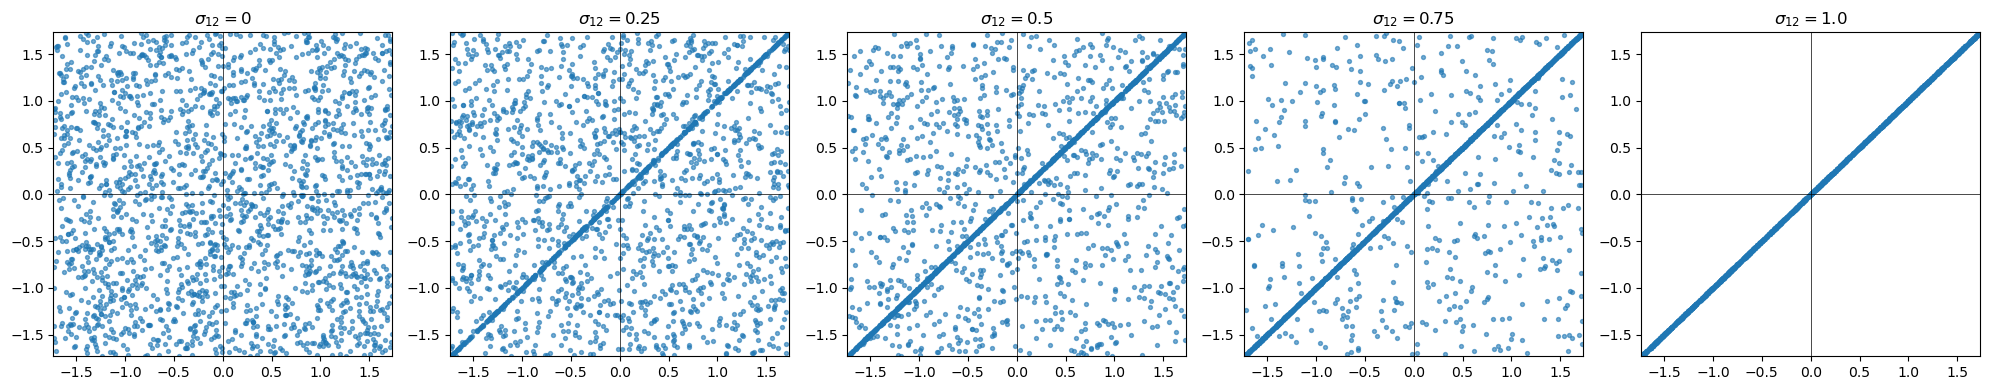

In [21]:
import numpy as np
import matplotlib.pyplot as plt

alpha, beta = -np.sqrt(3), np.sqrt(3)
rng = np.random.default_rng(42)

def generate_correlated_uniforms(n, sigma12):
    X1 = rng.uniform(alpha, beta, size=n)
    X2 = rng.uniform(alpha, beta, size=n)
    p = 1 - sigma12
    B = rng.binomial(1, p, size=n)
    V1 = X1
    V2 = (1-B)*X1 + B*X2
    return V1, V2

sigma_vals = [0, 0.25, 0.5, 0.75, 1.0]
n = 2000

fig, axes = plt.subplots(1, 5, figsize=(20,4))
for ax, sigma in zip(axes, sigma_vals):
    V1, V2 = generate_correlated_uniforms(n, sigma)
    ax.scatter(V1, V2, s=8, alpha=0.6)
    ax.set_title(f"$\\sigma_{{12}} = {sigma}$")
    ax.set_xlim(alpha, beta)
    ax.set_ylim(alpha, beta)
    ax.axhline(0, color='k', linewidth=0.5)
    ax.axvline(0, color='k', linewidth=0.5)

plt.tight_layout()
plt.show()


<hr>

**(e)** Using the above function, compute $\mathbb{P}[V_1\leq 0,V_2\leq 0]$ for the case when $\sigma_{12}=0.5$ (in a financial application, this can correspond to *both* $V_1$ and $V_2$ 'defaulting').

<hr>

## Ans.

In [26]:
import numpy as np

alpha, beta = -np.sqrt(3), np.sqrt(3)

def generate_correlated_uniforms(n, sigma12, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    X1 = rng.uniform(alpha, beta, size=n)
    X2 = rng.uniform(alpha, beta, size=n)
    p = 1 - sigma12
    B = rng.binomial(1, p, size=n)
    V1 = X1
    V2 = (1-B)*X1 + B*X2
    return V1, V2

# Estimate P(V1 <= 0, V2 <= 0) for sigma12 = 0.5
rng = np.random.default_rng(2025)
V1, V2 = generate_correlated_uniforms(n=2_000_000, sigma12=0.5, rng=rng)
prob_est = np.mean((V1 <= 0) & (V2 <= 0))
print(f"Estimated P[V1<=0, V2<=0] (sigma12=0.5): {prob_est:.4f}")



Estimated P[V1<=0, V2<=0] (sigma12=0.5): 0.3753


<hr>

**(f)** The Gaussian copula trick is based on first generating a multivariate normal vector with given covariance matrix $\Sigma$, and then using inversion to convert it to a vector of uniform rvs, which can then used to generate the desired rvs. We now demonstrate this in the above setting.

Let $\phi(\cdot)$ denote the 1-d normal cdf. Generate $(Z_1,Z_2)$ as multivariate normals with covariance
$\Sigma =\begin{pmatrix}
		1 & 0.5 \\
		0.5 & 1
	\end{pmatrix}$,
and define $W_1 = \alpha + (\beta-\alpha)\phi(Z_1)$ and $W_2 = \alpha + (\beta-\alpha)\phi(Z_2)$.

Argue $W_1$, $W_2$ are uniform on $[\alpha,\beta]$ (and hence $\mathbb{E}[W_1]=\mathbb{E}[W_2]=0,Var(W_1)=Var(W_2)=1$). Next, for $\sigma_{12}=0.5$ and $\alpha,\beta$ as above, write a function to generate $W_1,W_2$ as described, and use these to plot the scatter plot, and compute $\mathbb{P}[W_1\geq 0,W_2\geq 0]$.

<hr>

## Ans.

By the probability–integral transform, $U_i=\Phi(Z_i)\sim\text{Unif}(0,1)$.  
An affine map of a uniform remains uniform, so
$$
W_i=\alpha+(\beta-\alpha)U_i \sim \text{Unif}(\alpha,\beta).
$$
With $\alpha=-\sqrt{3}$ and $\beta=\sqrt{3}$, we have
$$
\mathbb{E}[W_i]=0,\qquad \operatorname{Var}(W_i)=1.
$$


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from scipy.stats import norm

rng = np.random.default_rng(7)

alpha, beta = -np.sqrt(3), np.sqrt(3)  # bounds
rho = 0.5                              # target correlation for Z

# Cholesky factor for [[1,rho],[rho,1]]
Sigma = np.array([[1.0, rho],
                  [rho, 1.0]])
L = cholesky(Sigma, lower=True)

def gaussian_copula_uniforms(n, alpha=alpha, beta=beta, rng=None):
    """
    Generate (W1, W2) via the Gaussian copula with correlation rho=0.5:
      1) Z ~ N(0, Σ), Σ=[[1,ρ],[ρ,1]]
      2) U = Φ(Z)  -> Unif(0,1)
      3) W = α + (β-α) U  -> Unif(α,β)
    """
    rng = np.random.default_rng() if rng is None else rng
    Z = rng.standard_normal(size=(n, 2)) @ L.T
    U = norm.cdf(Z)
    W = alpha + (beta - alpha) * U
    return W[:,0], W[:,1]

# Monte Carlo estimate of P(W1 ≥ 0, W2 ≥ 0)
n = 1_000_000
W1, W2 = gaussian_copula_uniforms(n, rng=np.random.default_rng(2025))
prob_ge0 = np.mean((W1 >= 0) & (W2 >= 0))
print(f"Estimated P(W1 ≥ 0, W2 ≥ 0) for ρ = {rho}: {prob_ge0:.4f}")



Estimated P(W1 ≥ 0, W2 ≥ 0) for ρ = 0.5: 0.3336


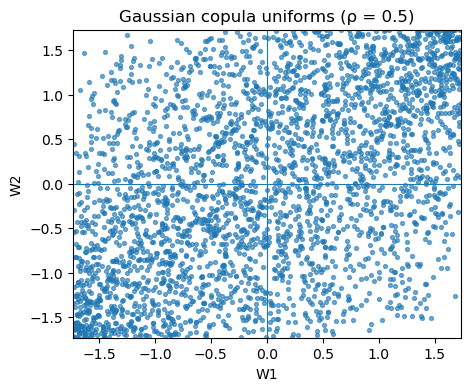

In [28]:
# A single scatter plot (small sample) to visualize dependence
W1s, W2s = gaussian_copula_uniforms(3000, rng=np.random.default_rng(12345))

plt.figure(figsize=(5,4))
plt.scatter(W1s, W2s, s=8, alpha=0.6)
plt.axhline(0, linewidth=0.8)
plt.axvline(0, linewidth=0.8)
plt.xlim(alpha, beta); plt.ylim(alpha, beta)
plt.title("Gaussian copula uniforms (ρ = 0.5)")
plt.xlabel("W1"); plt.ylabel("W2")
plt.show()
